#ATSC 405 Day 7 Assignment
##Bryan Jansens

---------

##First goal: Numerically integrate $\int_0^5x^2 \ dx$ using np.arange, np.diff and np.sum.
Think of adding up the area of a lot of thin boxes under the curve $f(x)=x^2$ between $x=0$ and $x=5$. To start, I create an array called data using numpy.arange, which contains equally-spaced values from 0 to 5 in steps of 0.01. These values are the $x$ values for me to use in the integration. The integral is then equal to the sum of the areas of all the thin boxes, which is equal to the "width" 0.01 of each box multiplied by its height. The height of each box is given by the value of $f(x)$ at that point, which is the value of $x$ at each step in data, squared. The exact result is known to be 125/3, or about 41.667, so let's see how close I can get.

In [1]:
import numpy as np

In [33]:
step_list = [0.1, 0.01, 0.001]
for step in step_list:
    data = np.arange(0,5.01,step)
    value = np.sum((data**2)*step)
    print('The numerical value is {:.3f}, which is {:.3f} away from the exact value.'.format(value, np.abs(value - 41.667)))

The numerical value is 42.925, which is 1.258 away from the exact value.
The numerical value is 41.792, which is 0.125 away from the exact value.
The numerical value is 41.905, which is 0.238 away from the exact value.


## Second goal: Plot pressure vs. height for a sounding. Calculate the scale height for this sounding using Lohmann (3.7) and add a line that plots $p(z)=p_0e^{-z/H}$.
First I need to bring in the code from newsounding.ipynb to get my sounding, and then I can plot pressure as a function of height. My location is Iqaluit.

In [34]:
from importlib import reload
import soundings.wyominglib
reload(soundings.wyominglib)
from soundings.wyominglib import make_frames
import pandas as pd
from matplotlib import pyplot as plt
import requests
import datetime
from datetime import timezone as tz
import tzlocal   #pip install tzlocal
import h5py
from pprint import pformat
print(help(make_frames))

Help on function make_frames in module soundings.wyominglib:

make_frames(html_doc)
    input: web page from wyoming upperair sounding site
           http://weather.uwyo.edu/cgi-bin/sounding retrieved by
           the requests module
    output: attr_dict dictionary with ['header', 'site_id','longitude','latitude', 'elevation', 'units']
            sound_dict soudning dictionary with sounding times as keys and sounding as dataframes

None


In [35]:
#this template holds the text that will always be the same,
# plus variables that will be substituted in based on dictionary values

url_template=("http://weather.uwyo.edu/cgi-bin/sounding?"
              "region={region:s}"
              "&TYPE=TEXT%3ALIST"
              "&YEAR={year:s}"
              "&MONTH={month:s}"
              "&FROM={start:s}"
              "&TO={stop:s}"
              "&STNM={station:s}")

In [36]:
values=dict(region='samer',year='2013',month='2',start='0100',stop='2800',station='71909')
#values=dict(region='nz',year='2013',month='2',start='0100',stop='2800',station='93417')
#values=dict(region='naconf',year='2013',month='2',start='0100',stop='2800',station='71802')
#values=dict(region='ant',year='2013',month='07',start='0100',stop='2800',station='89009')
url=url_template.format_map(values)
print('here is the url we call to get the soundings: \n',url)

here is the url we call to get the soundings: 
 http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=2&FROM=0100&TO=2800&STNM=71909


In [38]:
#
# Make do_web False to reuse a page for debugging
#
do_web = True
backup_file='backup.txt'
if do_web:
    #
    # grab the web page that is loaded with this url
    #
    html_doc = requests.get(url).text
    print('read {} bytes'.format(len(html_doc)))
    with open(backup_file,'w') as f:
        f.write(html_doc)
    if len(html_doc) < 2000:
        print('debug: short html_doc, something went wrong:',html_doc)
        sys.exit(1)
else:
    with open(backup_file,'r') as f:
        html_doc=f.read()

read 607756 bytes


In [39]:
attr_dict,sounding_dict = make_frames(html_doc)

header is:  71909 YFB Iqaluit Observations at 00Z 01 Feb 2013


In [40]:
mytz=tzlocal.get_localzone()
now=datetime.datetime.now(tz=mytz)
now=now.astimezone(tz.utc)
timestamp=now.strftime('%Y-%m-%d %H:%M:%S UTC')
print(timestamp)

2016-01-20 06:31:22 UTC


In [41]:
attr_dict['timestamp']=timestamp
attr_dict['history']="written by test_requests.py"
attr_dict['query']= url
#
# write the keys out in this order
#
key_list=['header', 'site_id','longitude','latitude', 'elevation', 'units','history','query','timestamp']

In [42]:
name = 'out.h5'    
with pd.HDFStore(name,'w') as store:
    for key,value in sounding_dict.items():
        #need to insert Y in front of the year because
        #h5py groups need to be legal python variables
        #(remove Y to see error message)
        thetime=key.strftime("Y%Y_%b_%d_%HZ")  
        store.put(thetime,value,format='table')

In [43]:
with h5py.File(name,'a') as f:
        for key in key_list:
            print('writing key, value: ',key,attr_dict[key])
            f.attrs[key]=attr_dict[key]
        f.close()

writing key, value:  header 71909 YFB Iqaluit Observations at 00Z 01 Feb 2013
writing key, value:  site_id 71909
writing key, value:  longitude -68.55
writing key, value:  latitude 63.75
writing key, value:  elevation 3.0
writing key, value:  units hPa;m;C;C;%;g/kg;deg;knot;K;K;K
writing key, value:  history written by test_requests.py
writing key, value:  query http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=2&FROM=0100&TO=2800&STNM=71909
writing key, value:  timestamp 2016-01-20 06:31:22 UTC


In [44]:
attributes={}
with h5py.File(name,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 3.0,
 'header': '71909 YFB Iqaluit Observations at 00Z 01 Feb 2013',
 'history': 'written by test_requests.py',
 'latitude': 63.75,
 'longitude': -68.549999999999997,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=samer&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=2&FROM=0100&TO=2800&STNM=71909',
 'site_id': '71909',
 'timestamp': '2016-01-20 06:31:22 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}


In [45]:
name = 'out.h5'    
separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(name,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[0]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))


++++++++++++++++++++++++++++++
sounding times:['/Y2013_Feb_01_00Z', '/Y2013_Feb_01_12Z', '/Y2013_Feb_03_00Z', '/Y2013_Feb_03_12Z', '/Y2013_Feb_04_00Z', '/Y2013_Feb_04_12Z', '/Y2013_Feb_05_00Z', '/Y2013_Feb_05_12Z', '/Y2013_Feb_06_12Z', '/Y2013_Feb_07_00Z', '/Y2013_Feb_07_12Z', '/Y2013_Feb_08_00Z', '/Y2013_Feb_08_12Z', '/Y2013_Feb_09_00Z', '/Y2013_Feb_09_12Z', '/Y2013_Feb_10_00Z', '/Y2013_Feb_10_12Z', '/Y2013_Feb_11_00Z', '/Y2013_Feb_11_12Z', '/Y2013_Feb_12_00Z', '/Y2013_Feb_12_12Z', '/Y2013_Feb_13_00Z', '/Y2013_Feb_13_12Z', '/Y2013_Feb_14_00Z', '/Y2013_Feb_14_12Z', '/Y2013_Feb_15_00Z', '/Y2013_Feb_15_12Z', '/Y2013_Feb_16_00Z', '/Y2013_Feb_16_12Z', '/Y2013_Feb_17_00Z', '/Y2013_Feb_17_12Z', '/Y2013_Feb_18_00Z', '/Y2013_Feb_18_12Z', '/Y2013_Feb_19_00Z', '/Y2013_Feb_19_12Z', '/Y2013_Feb_20_00Z', '/Y2013_Feb_20_12Z', '/Y2013_Feb_21_00Z', '/Y2013_Feb_21_12Z', '/Y2013_Feb_22_00Z', '/Y2013_Feb_22_12Z', '/Y2013_Feb_23_00Z', '/Y2013_Feb_23_12Z', '/Y2013_Feb_24_00Z', '/Y2013_Feb_24_12Z', '/Y2013

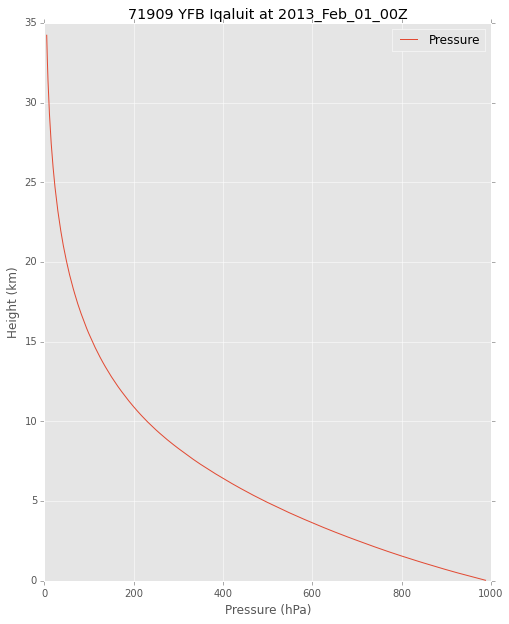

In [50]:
%matplotlib inline
key=times[3]  #pick the third sounding
the_sounding=sounding_dict[key]
m2km=1.e-3  #convert meters to km
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,10))
ax.plot(the_sounding['pres'],the_sounding['hght']*m2km, label = 'Pressure')
ax.legend()
out=ax.set(xlabel="Pressure (hPa)",ylabel="Height (km)",
      title=title)

Next I want to plot $p(z)=p_0e^{-z/H}$, with $p_0$ the pressure at the surface. This requires me to calculate the scale height $H$, from equation (3.7) in Lohmann:$\\[2mm]$

$$\frac{dp}{p}=-\frac{g}{R_d\overline{T_v}} \ dz.\\[2mm]$$

Setting the scale height as $H=R_d\overline{T_v}/g$ I can re-write this as$\\[2mm]$

$$\frac{dp}{p}=-\frac{1}{H} \ dz.\\[2mm]$$

In the above, $\overline{T_v}$ is the average temperature over each height interval $dz$. I need to use an average $\overline{H}$, but I'm not sure how (3.7) in Lohmann gives me that? I'll just try calculating the pressure integral, and integrate from the surface pressure to the top of the atmosphere, where pressure should be zero.

In [67]:
p0 = the_sounding['pres'][0]
print(p0)
zmax = the_sounding['hght'][133]
print(zmax)

988.0
34220.0


In [100]:
step = 0.01
press_data = np.arange(p0,0.,-step)
value = 1/(np.sum((1/press_data)*step)/(zmax))
print('The numerical value of H is {:.3f} km.'.format(value*m2km))

The numerical value of H is 2.833 km.


In [96]:
pressures = p0*np.exp(-the_sounding['hght']/value)

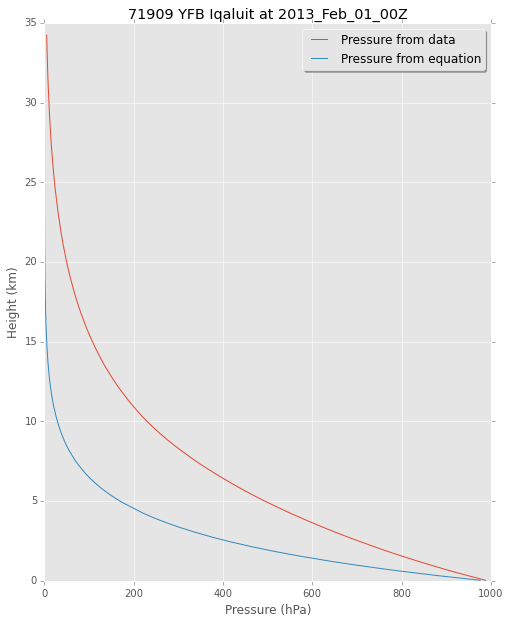

In [98]:
%matplotlib inline
key=times[3]  #pick the third sounding
the_sounding=sounding_dict[key]
m2km=1.e-3  #convert meters to km
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,10))
ax.plot(the_sounding['pres'],the_sounding['hght']*m2km, label = 'Pressure from data')
ax.plot(pressures,the_sounding['hght']*m2km, label = 'Pressure from equation')
out = ax.legend(loc='best', ncol=1, fancybox=True, shadow=True)
out=ax.set(xlabel="Pressure (hPa)",ylabel="Height (km)", title=title)

The scale height seems too small.